# 2022 Business Analytics Topic 5: Semi-Supervised Learning
## Unifying Semi-Supervised Learning and Unsupervised Domain Adaptation with AdaMath: PyTorch Implementation
### 2022010558 김지현 🐲

---

## Introduction

본 튜토리얼에서는 AdaMatch 알고리즘을 PyTorch로 구현할 것입니다. [AdaMatch: A Unified Approach to Semi-Supervised Learning and Domain Adaptation](https://arxiv.org/pdf/2106.04732.pdf)(by Berthelot et al.)는 2021년 6월 arxiv에 등재되었고 2022년 ICLR Conference에 Accept된 논문입니다. 2022년 12월 23일 기준 23회 인용되었으며, Semi-Supervised Learning(SSL)과 Unsupervised Domain Adaptation(UDA)를 하나의 Framework로 통일시켜 해결하였다는 점에서 높은 기여점을 가집니다. 이를 저자들은 'Semi-Supervised Domain Adaptation(SSDA)'라 합니다.

본 튜토리얼에서는 PyTorch를 통한 AdaMatch 알고리즘을 from the scratch로 구현하고자 하며, 코드에 대한 상세한 설명을 통해 AdaMatch에 대한 보다 깊은 이해를 가질 수 있도록 합니다. 이때, 본격적으로 AdaMatch에 대해 다루기 전에 'Semi-Supervised Learning'과 'Unsupervised Domain Adaptation' 분야에 대해 간략하게 짚고 넘어가겠습니다.

---

## Preliminaries

### Semi-Supervised Learning (SSL)

- **Semi-Supervised Learning(SSL)** 이란 모델을 학습하기 위한 Labeled Data의 수가 아주 적지만, Unlabeled Data의 수는 많은 상황에서 사용되는 준지도 학습 방법론입니다.    
    - '준'지도 학습이라는 말에서 알 수 있듯이, Labeled Data를 통해 풀고자 하는 Task에 대한 성능을 높이는 동시에(지도학습), Unlabeled Data를 적극 활용하여 추가적인 성능 향상(비지도 학습)을 목표로 하는 방법론입니다.
    - 만일 $x_{labeled}$와 $x_{unlabeled}$가 동일한 Marginal distribution으로부터 비롯되었다면, $x_{unlabeled}$의 분포를 잘 파악하는 것만으로도 $P(y|x)$ 값을 내뱉는 $f(x)$의 성능을 향상시킬 수 있지 않을까요?
    - 이처럼 '$x$에 대한 특징을 잘 이해한다면, $x$가 주어졌을 때 $y$를 잘 맞출 수 있을 것이다'는 아이디어에서 시작하는 방법론이 Semi-Supervised Learning입니다.   

　   

- 이처럼 **Semi-Supervised Learning은 Labeled Data와 Unlabeled Data가 모두 같은 데이터 분포로부터 비롯되었다는 가정을 두고 있습니다(Zhuang, 2020).** 따라서 두 데이터의 분포가 다른 경우에는 적절한 $x$의 특징을 찾는 것이 어려워져 성능이 하락할 수 있다는 한계를 가지게 되죠.
    - AdaMatch의 저자들이 지적하는 부분이 바로 이것입니다. 현실 상황에서는 대량의 Unlabeled Data가 Labeled Data와 유사하지만 조금 다른 분포를 가지는 경우도 있기 때문이죠. 이를테면 MNIST와 SVHN이 바로 그 예입니다.

### Unsupervised Domain Adaptation (UDA)

- 위에서 언급한 바와 같이, **데이터 간 분포가 다른 경우에 이 차이를 좁히고자 하는 대표적인 방법론이 Domain Adaptation(DA)** 입니다. 이때 Domain이란 하나의 분포로부터 비롯된 데이터셋을 지칭하는 용어입니다.
    - Domain Adaptation의 윗 갈래인 Transfer Learning(전이 학습)은 특정 Task(Classification, Regression)를 수행하기 위해 특정 Domain(Source Domain)으로 모델을 학습시킨 후, 다른 Domain(Target Domain)에 대해서도 Task 성능을 높이고자 할 때 사용되는 방법론을 지칭합니다.
    - 이때 Source Domain의 데이터는 모델을 학습시킬 만큼 충분하지만 Target Domain의 데이터는 그렇지 않을 때, 분포는 조금 다를지라도 Source Domain의 지식을 활용하여 Target Domain에 대한 성능을 높일 수 있을 것입니다. 이처럼 Labeled Source Domain의 지식을 활용해 Target Domain에서도 높은 Task 성능을 내는 것을 목표로 하는 방법론이 Domain Adaptation입니다. 
        - Domain Adpatation에서는 Feature Space 상에서 일어나는 Domain 간 분포 차이(Domain Shift)를 직접적으로 해결하고자 하는데, Maximum Mean Discrepancy(MMD) 등의 지표로 분포 차이를 줄이도록 학습하거나 Adversarial Learning으로 도메인 차이에 강건한(Domain-invariant) Representation을 추출합니다. 
    
    　   
- **Unsupervised Domain Adaptation** 은 Target Domain에 Label이 없는 상황을 가정합니다. 그렇다면 우리가 성능을 높이고자 하는 Target Domain은 데이터가 적어 Self-Supervised Learning을 활용하기도 어렵고, Label도 없어 Fine Tuning 을 적용하기도 어려운 상황이죠. (Unsupervised Domain Adaptation에 대해 추가 설명이 필요하신 분들은, [해당 세미나](http://dmqm.korea.ac.kr/activity/seminar/379)를 참고하시면 좋습니다)
    - 이때 위에서 서술한 방법론으로 대량의 Labeled Source Domain의 지식을 활용해 Unlabeled Target Domain의 성능을 향상시킬 수 있습니다.
    - AdaMatch의 저자들은, 이러한 Unsupervised Domain Adaptation의 상황에서 동작할 수 있는 Framework를 제안합니다.

　   

- 더불어 Target Domain에 Label의 일부가 있을 때에는 Semi Supervised Learning과 Domain Adaptation 테크닉을 함께 활용하여 문제를 풀어나갈 수 있을 것입니다. 이를 SSDA라 지칭하며, 각 방법론 별 문제 상황은 아래 도표와 같습니다. (원문 Section 1의 Table 1 참고)

### Relations between the settings of Semi-Supervised Learning(SSL), Unsupervised Domain Adaptaiton(UDA), and Semi-Supervised Domain Adaptation(SSDA)

| __Task__ | __Labeled__ | __Unlabeled__ | __Distribution__ |
| -------- | ----------- | ------------- | ---------------- |
| __SSL__  | Source Domain| Target Domain | Source = Target |
| __UDA__  | Source Domain| Target Domain | Source ≠ Target |
| __SSDA__  | Source Domain+Target Domain| Target Domain | Source ≠ Target |

---

## Setup

이제 본격적으로 AdaMatch를 PyTorch로 구현해보겠습니다. 먼저 필요한 Library를 Import해줍니다.

In [1]:
import os, time, shutil, math, rich, logging, random, collections, datetime
import deeplake, argparse

import numpy as np
from rich.progress import Progress

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("hls")

# Logging
from rich.console import Console
from rich.logging import RichHandler
from rich.progress import Progress

import warnings
warnings.filterwarnings("ignore")

c:\Users\JihyunKim\anaconda3\envs\torch\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.1.5) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


### Define parser (hyperparameter)

위와 같이 AdaMatch에 사용될 parser를 미리 지정하였습니다. AdaMatch 구현에 있어 특히 필요한 argument에 대한 설명은 아래에 서술되었습니다.

In [2]:
ADAparser = argparse.ArgumentParser()
ADAparser = argparse.ArgumentParser()

# Directory
ADAparser.add_argument("--data-dir", default='./Data/', type=str)
ADAparser.add_argument("--top-save-dir", default='./Results/', type=str)

# Seed
ADAparser.add_argument("--seed", default=2022, type=int)

# Model hyperparameter
ADAparser.add_argument("--n-classes", default=345, type=int, help="num of classes in dataset")

# Data hyperparameter
ADAparser.add_argument("--img-size", default=32, type=int, help="Resized Img size")
ADAparser.add_argument("--train-size", default=3000, type=int),
ADAparser.add_argument("--test-size", default=1500, type=int)

# Training hyperparameter
ADAparser.add_argument("--uratio", default=2, type=int, help="During training, (uratio)x more target unlabeled samples are shown to be model")
ADAparser.add_argument("--epochs", default=20, type=int, help="epochs")
ADAparser.add_argument("--source-batch-size", default=64, type=int, help="Batch size of source domain")
ADAparser.add_argument("--target-batch-size", default=64*2, type=int, help="Batch size of target domain")
ADAparser.add_argument("--optimizer", default='adam', type=str)
ADAparser.add_argument("--lr", default=0.03, type=float, help="learning rate.")
ADAparser.add_argument("--weight-decay", default=0.0005)
ADAparser.add_argument("--scheduler", default="cosine", type=str, choices=['step', 'cosine'], 
                    help="This scheduler increases the weight of the target domain loss from 0 to 1 for the first half of the training")
ADAparser.add_argument("--tau", default=.9, type=float, help="Confidence threshold.")
   
args = ADAparser.parse_args(args=[])

[Model Hyperparamter]
- `n_classes`: 본 튜토리얼에서 사용할 데이터셋인 DomainNet의 class 개수(category)는 총 345개입니다.

[Data Hyperparameter]
- `img_size`: 이미지를 resize 할 때의 값입니다. 원문에서는 224x224를 기본으로 하되, 컴퓨팅 자원이 낮은 환경에서는 64x64로 학습을 권장하였습니다. 더불어 Section 4의 'Democratic research' part를 참고하면 DomainNet에 대하여 64x64도 충분히 SOTA 성능을 달성하였다고 밝히고 있습니다.
    - 이때 본 튜토리얼에서는 32x32를 사용합니다.
- `train_size`, `test_size`: 원 데이터셋의 이미지 관측치 개수는 source_train 120,906개, source_test 54,421개, target_train 33,525 target_test 15,308개입니다. 이때 일괄적으로 Domain에 관계 없이 지정된 train_size/test_size에 맞게 데이터 개수를 조절해줍니다.
    - 튜토리얼의 목적은 AdaMatch알고리즘을 PyTorch로 구현하는 것이기에, 기본 성능만 확인하고자 데이터 관측치 개수를 train 3000개, test 1500개로 대폭 줄였습니다.

[Train hyperparameter]
- `uratio`: 학습 과정 중 Label이 없는 Target Domain의 데이터는 uratio만큼 더 모델이 학습하도록 합니다. 원문 Section 3.2를 참고하면 3으로 설정되어 있지만, 본 튜토리얼에서는 컴퓨팅 자원의 한계를 고려하여 2로 설정하였습니다.
- `lr` & `weight_decay`: 원문 section 4를 보면, Wide ResNet-28-2 모델에 대해서 learning rate은 0.03, weight decat는 0.0005를 사용했다고 밝히고 있습니다. 따라서 해당 값을 그대로 사용하였습니다.
- `scheduler`: AdaMatch 원문에서는 learning rate scheduler를 이용함에 있어 cosine decay를 사용하습니다.
- `tau`: Pseudo Label 지정에 있어 Global Confidence($\tau$)입니다. 논문에서는 0.9를 사용하였습니다.
    - 이때 AdaMatch는 Relative Confidence Threshold를 사용하기에, Source Domain의 Weakly Augmented Sample의 Max Confidence의 값을 곱하여 매 Batch마다 다른 Confidence를 사용하게 됩니다.

### Set GPU and Seed

In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print('The number of GPUs available: {}'.format(torch.cuda.device_count()))
    
device = "cuda" if torch.cuda.is_available() else "cpu" 
print("device:", device)

NVIDIA GeForce RTX 2080 Ti
The number of GPUs available: 1
device: cuda


- 모델 학습에 사용될 GPU와 seed 값을 사전에 지정합니다. 본 튜토리얼에서는 cuda를 이용해 GPU를 사용할 것입니다.

In [4]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(args.seed)

- 실험 재현성을 위해 seed를 고정합니다. 사전에 정의된 seed는 2022입니다. 이제 곧 2022년이 끝나고 2023을 seed로 사용할 날이 다가오고 있네요.

### Make checkpoint directory

In [11]:
# Define and Make ckpt directory
result_dir = os.path.join(args.top_save_dir, f'{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}')
os.makedirs(result_dir, exist_ok=True)
print(result_dir)

./Results/2022-12-27_13-32


- Checkpoint directory를 만들겠습니다. 학습이 완료된 후 가장 validation 성능이 좋았던 모델 파라미터를 저장하는 공간입니다. 편의상 코드 실행 날짜를 생성하여 결과 저장 공간으로 사용합니다.

----

## Prepare Dataset & Dataloader

In [5]:
# Source Domain -> DomainNet, real
source_train = deeplake.load("hub://activeloop/domainnet-real-train")[:args.train_size]
source_test = deeplake.load("hub://activeloop/domainnet-real-test")[:args.test_size]

# Target Domain -> DomainNet, clipart
target_train = deeplake.load("hub://activeloop/domainnet-clip-train")[:args.train_size]
target_test = deeplake.load("hub://activeloop/domainnet-clip-test")[:args.test_size]

hub://activeloop/domainnet-real-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/domainnet-real-train
hub://activeloop/domainnet-real-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/domainnet-real-test
hub://activeloop/domainnet-clip-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/domainnet-clip-train
hub://activeloop/domainnet-clip-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/domainnet-clip-test


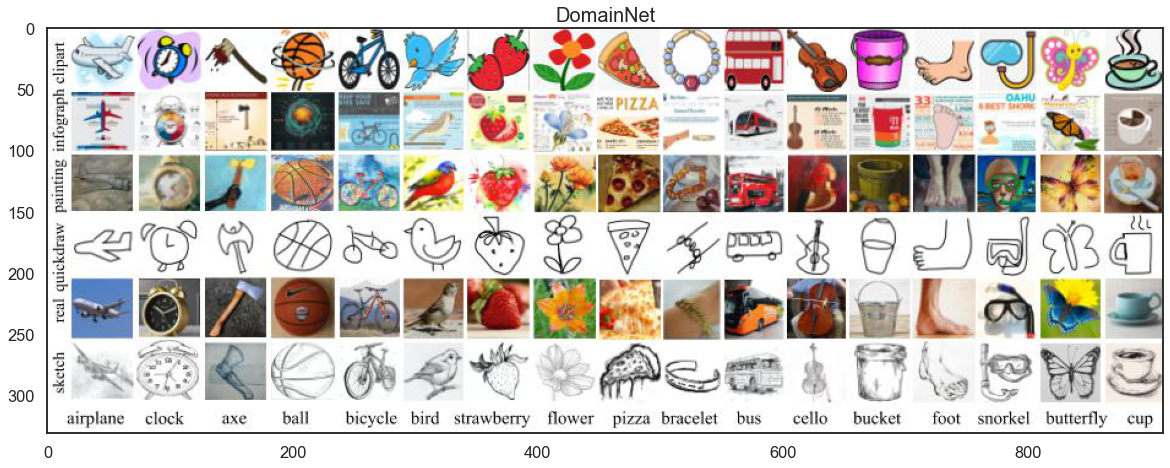

In [7]:
img = Image.open('./Img/1.jpg')

img_np = np.asarray(img)

plt.figure(figsize=(20, 10))
plt.imshow(img_np)
plt.title("DomainNet", fontsize=20);

In [8]:
print('num categories of DomainNet (Source Domain): ', np.unique(source_train['labels'].numpy()).__len__())
print('num categories of DomainNet (Target Domain): ', np.unique(target_train['labels'].numpy()).__len__())

num categories of DomainNet (Source Domain):  345
num categories of DomainNet (Target Domain):  345


- 본 튜토리얼에서 사용할 데이터셋은 `DomainNet`입니다. `DomainNet`은 6가지의 서로 다른 도메인의 데이터셋을 담고 있으며, 총 345개의 Class로 이루어져 있습니다.
- 각 도메인은 같은 Class와 같은 Classification Task를 수행하지만, 데이터의 Marginal Distribution이 서로 다릅니다.
- 이때 AdaMatch에서는 Domain Adaptation을 이용하여 Test 성능을 높이고자 하는데, Source Domain과 Target Domain이 각각 하나인 Single Source-Single Target 상황을 가정하는 알고리즘입니다.
- 따라서 DomainNet의 6개 Domain 중, __본 튜토리얼에서는 `real` Domain을 Label이 있는 Source Domain으로, `clipart`를 Target Domain__ 으로 두었습니다.

- DomainNet은 `deeplake` API를 이용하여 불러올 수 있습니다. `deeplake`는 딥러닝 모델 학습을 위한 오픈 소스 데이터셋을 쉽게 처리하기 위한 여러 모듈들을 제공하고 있으며, [참고 링크](https://datasets.activeloop.ai/docs/ml/datasets/domainnet-dataset/)를 따라가시면 사용법을 더 쉽게 파악하실 수 있습니다.

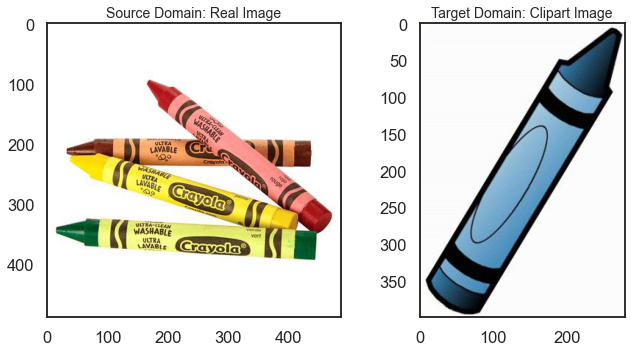

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Source Domain: Real Image", fontsize=14)
plt.imshow(source_train.images[0].numpy());
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.title("Target Domain: Clipart Image", fontsize=14)
plt.imshow(target_train.images[0].numpy())
plt.tight_layout()

- DomainNet의 Source/Target Domain 중 하나의 데이터셋을 일부 불러와 시각화 해보겠습니다.
- 같은 Class (crayon)에 대해서, Real Image를 담은 Source Domain과 Clipart Image를 담은 Target Domain의 이미지가 서로 다릅니다.
- 이처럼 데이터의 두 분포가 다른 상황에서, AdaMatch가 Target Domain에서 강건한 성능을 낼 수 있는지 실험적으로 확인해보도록 하겠습니다.

### Data Augmentation Utilities

- Augmentation은 위와 같이 정의합니다. 논문에서는 Weak Augementation을 'shift', 'mirror about the $x$ axis'라 정의하였습니다. 더불어 Strong Augmentation은 'Weak Augmentation + cutout'으로 지정합니다. 그리고 코드를 확인해보면 CT Augment를 사용하는데, 원본 코드는 tensorflow를 기반으로 작업하였습니다.
- 본 튜토리얼은 AdaMatch를 PyTorch로 구현하는 것입니다. 따라서 [참고 사이트](https://blog.joonas.io/193)를 바탕으로 `torchvision`의 `transforms`에서 제공하는 모듈들을 바탕으로 Weak/Strong Augmentation을 정의하였습니다.
- 추가적으로, 이미지 사이즈가 서로 다르기 때문에 (32, 32, 3) 사이즈로 일괄적으로 맞추는 작업을 진행합니다.
    - 이때 컴퓨터 자원에 따라서 이미지 해상도를 더 크게 키우는 것도 가능합니다.

In [6]:
## Define Augmentation ##
# Train: weak, strong
weak_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    
    # Resize Img as [args.img_size, args.img_size, 3]
    transforms.Resize((args.img_size, args.img_size)),
    
    # Mirror on x-axis
    transforms.RandomHorizontalFlip(),
    
    # Shift
    transforms.RandomResizedCrop((args.img_size, args.img_size))
])

strong_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    
    # Resize Img as [args.img_size, args.img_size, 3]
    transforms.Resize((args.img_size, args.img_size)),
    
    # Mirror on x-axis
    transforms.RandomHorizontalFlip(),
    
    # Shift
    transforms.RandomResizedCrop((args.img_size, args.img_size)),
    
    # Cutout
    transforms.RandomErasing(),
    
    # 추가 Strong Augment (implemented a pipeline similar to CTAugment using the availabe torchvision transforms)
    transforms.RandomInvert(),
    transforms.RandomAdjustSharpness(random.uniform(0, 1)),
    transforms.RandomAutocontrast(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1.))
])

# Test
test_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    
    # Resize Img as [args.img_size, args.img_size, 3]
    transforms.Resize((args.img_size, args.img_size))
])

- DataLoader 역시 `deeplake` API를 이용하여 정의합니다. 기존의 `torch.utils.data.DataLoader`에서 제공하는 것과 거의 동일한 문법을 사용하여 정의할 수 있습니다.
- 이때 AdaMatch는 Source Domain과 Target Domain 모두에 대해 Weak/Strong Augmentation을 각각 수행합니다.
    - 따라서 사전 정의한 Weak/Strong Augmentation을 Source/Target에 모두 적용할 것입니다.
- Target의 batch size는 source의 uratio를 곱한 값이며, 원문에서는 3을 사용하였습니다Section 3.2 참고). 그러나 컴퓨팅 자원의 한계로 인하여 본 튜토리얼에서는 2로 설정하였습니다.
    - 이는 Unlabeled Target Domain이 학습 과정 동안 2배 더 활용되도록 하는 것입니다.

In [7]:
# Define and Get Dataloader

# Source Domain Dataloader
kwargs_source = {'batch_size': args.source_batch_size, 'drop_last': False, 'pin_memory': True, 'num_workers': 0}
source_weak_loader = source_train.pytorch(**kwargs_source, shuffle=False,
                                        transform={'images': weak_aug, 'labels': None})
source_strong_loader = source_train.pytorch(**kwargs_source, shuffle=False,
                                        transform={'images': strong_aug, 'labels': None})
source_test_loader = source_test.pytorch(**kwargs_source, shuffle=True,
                                        transform={'images': test_aug, 'labels': None})

# Target Domain Dataloader
kwargs_target = {'batch_size': args.source_batch_size*args.uratio, 'drop_last': False, 'pin_memory': True, 'num_workers': 0}
target_weak_loader = target_train.pytorch(**kwargs_target, shuffle=False,
                                        transform={'images': weak_aug, 'labels': None})
target_strong_loader = target_train.pytorch(**kwargs_target, shuffle=False,
                                        transform={'images': strong_aug, 'labels': None})
target_test_loader = target_test.pytorch(**kwargs_target, shuffle=True,
                                        transform={'images': test_aug, 'labels': None})

In [11]:
for batch in source_weak_loader:
    data, label = batch['images'], batch['labels']
    break

print(data[0].size())
print(len(source_weak_loader), len(target_weak_loader))

torch.Size([3, 32, 32])
47 24


- Batch 내 데이터 사이즈를 확인해보니, transform이 잘 적용된 것 같습니다. 이제 아래에서 이미지 시각화를 통해 Weak/Strong Augmentation 결과를 Source와 Target에 대해 각각 확인해보겠습니다.
- 더불어 target domain의 loader 길이는 훨씬 짧은데, 이는 batch size가 source에 비해 2배 더 크기 때문입니다.

### Source Domain (`real`) Dataloader Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


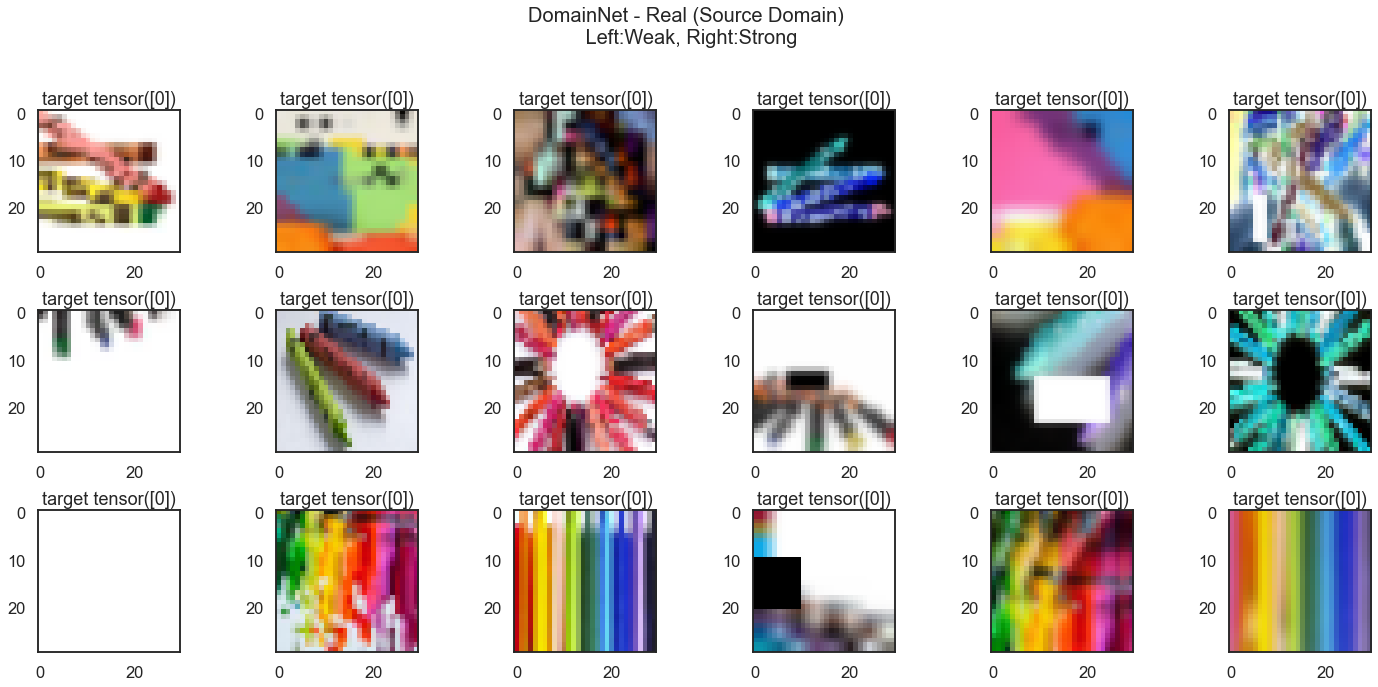

In [11]:
for batch in source_weak_loader:
    weak_data, weak_label = batch['images'], batch['labels']
    break

for batch in source_strong_loader:
    strong_data, strong_label = batch['images'], batch['labels']
    break

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
for i in range(9):
    img = np.transpose(np.array(weak_data[i]).astype(np.float32), (1, 2, 0))
    ax[i//3][i % 3].set_title(f"target {weak_label[i]}")
    ax[i//3][i % 3].imshow(np.asarray(img))
for i in range(9):
  img = np.transpose(np.array(strong_data[i]).astype(np.float32), (1, 2, 0))
  ax[i//3][3 + i % 3].set_title(f"target {strong_label[i]}")
  ax[i//3][3 + i % 3].imshow(np.asarray(img))
  
fig.suptitle('DomainNet - Real (Source Domain) \n Left:Weak, Right:Strong', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Target Domain (`clipart`) Dataloader Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


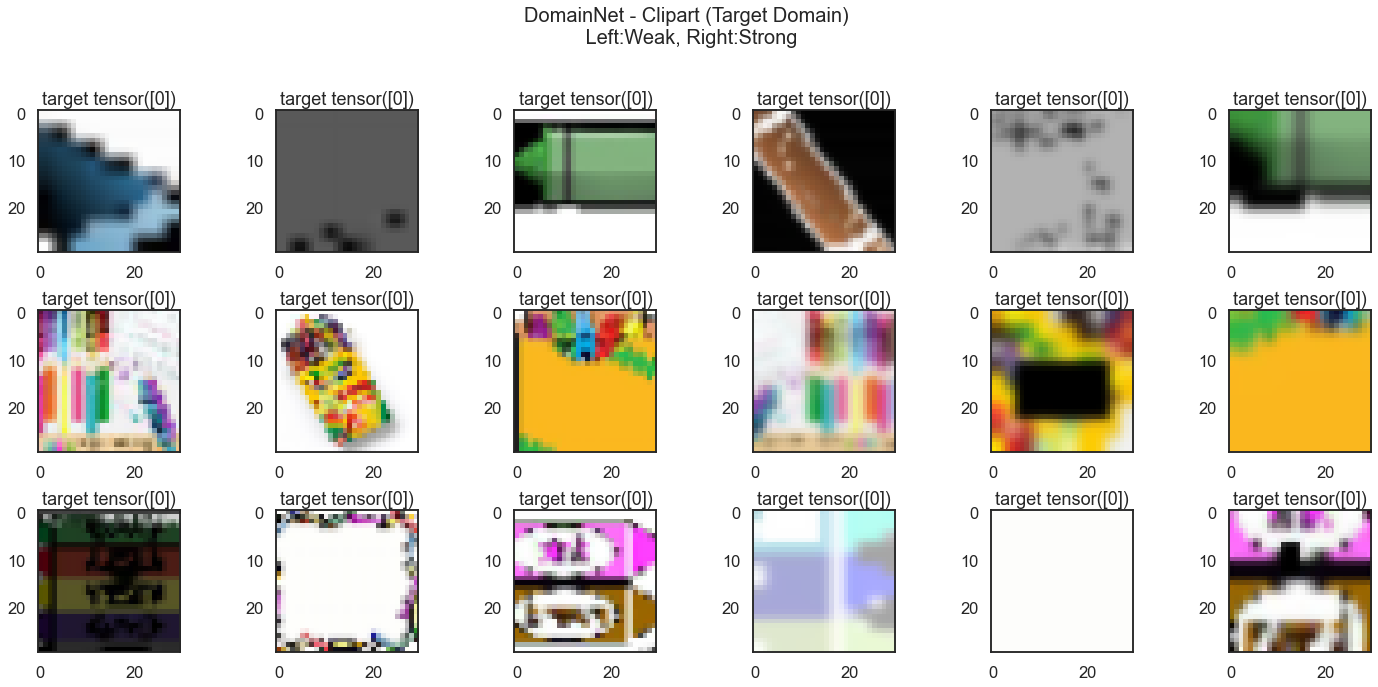

In [12]:
for batch in target_weak_loader:
    weak_data, weak_label = batch['images'], batch['labels']
    break

for batch in target_strong_loader:
    strong_data, strong_label = batch['images'], batch['labels']
    break

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
for i in range(9):
    img = np.transpose(np.array(weak_data[i]).astype(np.float32), (1, 2, 0))
    ax[i//3][i % 3].set_title(f"target {weak_label[i]}")
    ax[i//3][i % 3].imshow(np.asarray(img))
for i in range(9):
  img = np.transpose(np.array(strong_data[i]).astype(np.float32), (1, 2, 0))
  ax[i//3][3 + i % 3].set_title(f"target {strong_label[i]}")
  ax[i//3][3 + i % 3].imshow(np.asarray(img))
  
fig.suptitle('DomainNet - Clipart (Target Domain) \n Left:Weak, Right:Strong', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- 두 도메인 모두 Weak Augmentation는 Random으로 Shift되거나 x축으로 Flip 되어 있습니다. 반면 Strong Augment는 조금 더 이미지가 변형된 것을 시각적으로 확인하였습니다.

- 다만, __이미지를 32x32로 Resize하는 과정에서 해상도가 일부 손상된 것을 확인__ 하였습니다. 따라서 Category 개수가 345개나 되는 Multi Classification Task에 대한 성능이 높기를 기대하기는 힘들지만, 튜토리얼의 목적에 맞게 AdaMatch 알고리즘 구현을 정확히 하는 것에 초점을 두었습니다.

----

## Model

- 필요한 Model은 이미지 데이터의 Feature를 잘 추출할 수 있는 Backbone Encoder와 Classifier입니다. 
- 원문에서는 [WideResNet-28-2](https://arxiv.org/abs/1605.07146)을 사용하였으며, 본 튜토리얼에서는 [참고 github](https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/wide_resnet.py)를 통해 Wide ResNet을 구축하였습니다.
    - 본 튜토리얼에서도 원문과 마찬가지로 WideResNet의 depth는 28, widen-factor는 2로 설정 하였습니다.
    - WideResNet은 Pixel 값을 [0, 1] 사이로 조정해주는 Scaling Layer를 내포하고 있습니다.

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        nn.init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4) % 6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        # feature extractor
        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        
        # classifier
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

### Subclassed Model for AdaMatch Training

- AdaMatch에서는 Cosine learning rate scheduler를 사용하였습니다. 따라서 [참고 github](https://huggingface.co/transformers/v1.2.0/_modules/pytorch_transformers/optimization.html)을 기반으로 Cosine Scheduler Class를 사전에 구축합니다.

In [9]:
class WarmupCosineSchedule(optim.lr_scheduler.LambdaLR):
    def __init__(self,
                 optimizer,
                 warmup_steps: int,
                 t_total: int,
                 cycles: float = 0.5,
                 min_lr: float = 0.,
                 last_epoch: int = -1):
        
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        self.min_lr = min_lr
        self.base_lr = optimizer.defaults['lr']
        
        super(WarmupCosineSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step: int):
        """A lambda function used as argument for `LambdaLR`."""
        if step < self.warmup_steps:
            return float(step) / float(max(1, self.warmup_steps))
        else:
            progress = float(step - self.warmup_steps) / float(max(1, self.t_total - self.warmup_steps))
            mul = max(0., 0.5 * (1. + math.cos(math.pi * float(self.cycles) * 2.0 * progress)))
            if self.expected_lr(mul) < self.min_lr:
                return self.min_lr / self.base_lr
            else:
                return mul

    def expected_lr(self, mul: float):
        return self.base_lr * mul

## Task: Train & Evaluate AdaMatch Algorithm

- AdaMatch를 학습 및 평가 할 Task Class `AdaMatch`를 구축하였습니다. AdaMatch의 기본 동작 원리에 기반한 Workflow는 아래와 같습니다.
- 아래 그림은 원문에 그려져 있는 Overall workflow를 도식화 한 것입니다.

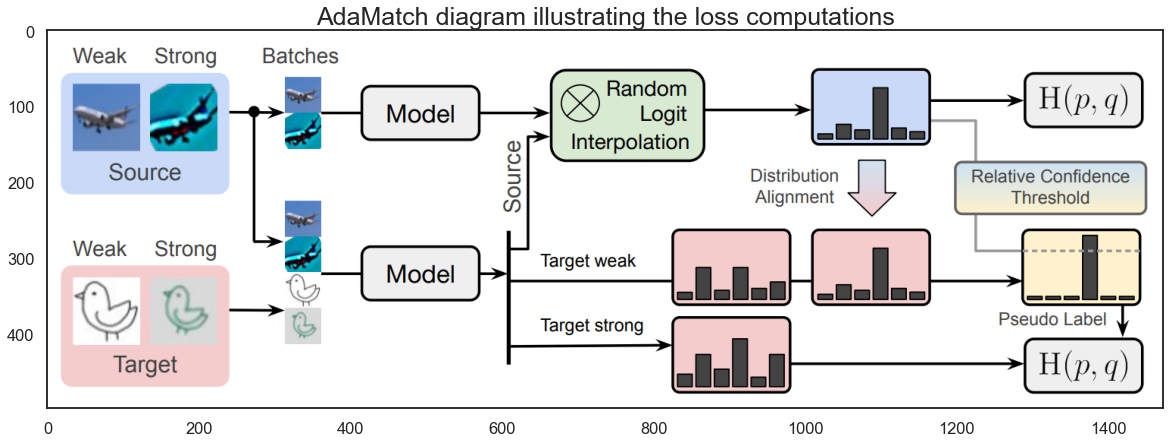

In [35]:
adamatch_img = Image.open('./Img/2.png')

adamatch_img_np = np.asarray(adamatch_img)

plt.figure(figsize=(20, 10))
plt.imshow(adamatch_img_np)
plt.title("AdaMatch diagram illustrating the loss computations", fontsize=25);

### Workflow of AdaMatch
1. **Augmentation** : AdaMatch는 Source Domain과 Target Domain 모두에 대하여 Weak/Strong Augmentation은 한 번씩 수행합니다.

　   

2. **Forward** : 동일한 Model(WideResNet)에 대하여 Batch 별 Forward를 2번 수행합니다.   
    __2-1.__ 첫 번째 Forward Pass: Source와 Target을 합한 input을 활용   
    __2-2.__ 두 번째 Forward Pass: Source input만을 활용

　   


3. **Random Logit Interpolation** : 첫 번째 Forward Pass를 통해 도출된 Output(logit) 값과 두 번째 Forward Pass를 통해 도출된 Output(logit) 값을 선형 보간법을 통해 하나의 Output 값으로 정의합니다.

　   


4. **Distribution Alignment** : Weakly Augmentated Source Logit과 Weakly Augmented Target Logit 간의 분포를 조정하여 최종 Pseudo Label 생성   
    __4-1.__ 실제 Label의 분포와의 조정을 시도한 [ReMixMatch](https://arxiv.org/pdf/1911.09785.pdf)와는 다른 방식   

　   


5. **Relative Confidence Threshold** : Weakly Augmented Source Domain의 confidence 수준에 따라 사전에 지정한 Global Threshold($\tau$) 조정

　   


6. 3에 따른 Source Domain의 Loss와 4, 5에 따른 Target Domain의 Loss를 각각 계산한 뒤 둘을 합침   
    __6-1.__ $Loss_{overall} = L_{source} + L_{target}$

그렇다면 'Random Logit Interpolation', 'Distribution Alignment', 'Relative Confidence Threshold'란 정확히 무엇일까요? 이는 아래에서 보다 자세히 설명하겠습니다.

In [11]:
class AdaMatch():
    """
    Paper: AdaMatch: A Unified Approach to Semi-Supervised Learning and Domain Adaptation (2021.06)
    """
    def __init__(self, args, device, result_dir):
        self.args = args
        self.device = device
        self.ckpt_dir = result_dir
        self.seed = args.seed
        
        # self.model = AdaMatchNet()
        model = Wide_ResNet(depth=28, widen_factor=2, dropout_rate=0.1, num_classes=args.n_classes)
        self.model = model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.args.lr, weight_decay=self.args.weight_decay)
        self.scheduler = self.get_scheduler(optimizer=self.optimizer, name=self.args.scheduler, epochs=self.args.epochs)
        
    def run(self, logger):
        writer = SummaryWriter(self.ckpt_dir)
        train_dataset = zip(source_weak_loader, source_strong_loader, 
                            target_weak_loader, target_strong_loader)
        
        best_acc = 0.0
        with Progress(transient=True, auto_refresh=False) as pg:
            task = pg.add_task(f"[bold purple] Training...", total=self.args.epochs)
            
            for epoch in range(1, self.args.epochs+1):
                desc = f"[bold magenta] [Current_epoch={epoch} / Total_epochs={self.args.epochs}] Training |"
                pg.update(task, advance=1., description=desc)
                pg.refresh()
                
                # Train & Evaluate
                model, train_result = self.train(train_dataset)
                source_acc = self.evaluate(source_weak_loader, model)
                target_acc = self.evaluate(target_weak_loader, model)
                test_acc = self.evaluate(target_test_loader, model)
                
                self.epoch_history = collections.defaultdict(dict)
                for k, v in train_result.items():
                    self.epoch_history[k]['train'] = v
                    
                self.epoch_history['accuracy']['source'] = source_acc
                self.epoch_history['accuracy']['target'] = target_acc
                    
                # Write Tensorboard Summary
                for k, v in self.epoch_history.items():
                    for k_, v_ in v.items():
                        writer.add_scalar(f"{k}_{k_}", v_, global_step=epoch)
                
                # Save checkpoint
                if test_acc > best_acc:
                    torch.save(model.state_dict(), os.path.join(self.ckpt_dir, 'best_model.pth'))
                    best_acc = test_acc
                    best_epoch = epoch
                
                # Logging
                log = self.make_epoch_description(
                    history=self.epoch_history,
                    current=epoch,
                    total=self.args.epochs,
                    best=best_epoch
                )
                logger.info(log)
                
                self.scheduler.step()
            
            best_ckpt = torch.load(os.path.join(self.ckpt_dir, 'best_model.pth'))
            model.load_state_dict(best_ckpt)
            
            return model, self.epoch_history
            
        
    def train(self, dataset):
        self.model.train()
        
        # For calculate mu (weight for target domain loss)
        steps = max(len(source_weak_loader), len(source_strong_loader), len(target_weak_loader), len(target_strong_loader))
        total_steps = steps * self.args.epochs
        current_steps = 0
        
        result = {
            'loss': torch.zeros(steps, device=self.device)
        }
        
        for i, batch in enumerate(dataset):
            (source_weak, source_labels), (source_strong, _), (target_weak, _), (target_strong, _) = batch
            source_weak, source_labels = source_weak.to(self.device), source_labels.to(self.device)
            source_strong = source_strong.to(self.device)
            target_weak, target_strong = target_weak.to(self.device), target_strong.to(self.device)
            
            # for 1st forward -> {source, target}
            input_all = torch.cat([source_weak, source_strong, target_weak, target_strong])
            # for 2nd forward -> {source}
            input_source = torch.cat([source_weak, source_strong])
            
            self.optimizer.zero_grad()
            
            # 1st forward -> {source, target}
            logits_all = self.model(input_all)
            # 2nd forward -> {source}
            logits_source_prime = logits_all[:input_source.shape[0]]
            
            # Do not update batchnorm statistics (when cal logits with only source batch) -> eval mode on
            self.tracking_BN_statistics(self.model, do_track=False)
            logits_source_2prime = self.model(input_source)
            # update batchnorm statistics (train again)
            self.tracking_BN_statistics(self.model, do_track=True)
            
            # 1. Random Logit Interpolation
            random_lambda = torch.rand_like(logits_source_prime).to(self.device)
            logit_source_final = (random_lambda * logits_source_prime) + ((1-random_lambda) * logits_source_2prime)
            
            # 2. Distribution Alignment
            ## 2-1. Weakly augmented source logits will be a ground truth when align logits distribution
            logits_source_weak = logit_source_final[:source_weak.shape[0]]
            pseudo_label_source = nn.Softmax(dim=1)(logits_source_weak)
            
            ## 2-2. Align Weakly augmented target logits distribution to weakly augmented source logits distribution
            logits_target = logits_all[input_source.shape[0]:]
            logits_target_weak = logits_target[:target_weak.shape[0]]
            pseudo_label_target = nn.Softmax(dim=1)(logits_target_weak)
            
            ratio_of_expected_value = (1e-6+torch.mean(pseudo_label_source)) / (1e-6+torch.mean(pseudo_label_target))
            final_pseudo_label = F.normalize((pseudo_label_target*ratio_of_expected_value), p=2, dim=1)  # L2 Normalization
            
            # 3. Relative Confidence Threshold (c_tau)
            pseudo_label_source_max = torch.max(pseudo_label_source, dim=1)[0]
            c_tau = self.args.tau * torch.mean(pseudo_label_source_max, 0)
            
            final_pseudo_label_max, final_pseudo_label = torch.max(final_pseudo_label, dim=1)
            mask = (final_pseudo_label_max >= c_tau).float()
            
            # 4. Loss
            source_criterion = nn.CrossEntropyLoss(reduction="mean")
            target_criterion = nn.CrossEntropyLoss(reduction="none")
            
            ## 4-1. Source Loss
            source_weak_loss = source_criterion(logits_source_weak, source_labels.squeeze(dim=-1))
            source_strong_loss = source_criterion(logit_source_final[source_weak.shape[0]:], source_labels.squeeze(dim=-1))
            source_loss = (source_weak_loss + source_strong_loss) / 2
            
            ## 4-2. Target Loss
            pseudo_label = final_pseudo_label.detach()  # Stop gradient -> prevents gradient from backpropagating on its argument
            target_strong_loss = target_criterion(logits_target[target_weak.shape[0]:], pseudo_label)
            target_loss = (target_strong_loss * mask).mean()
            
            ### 4-2-1. Compute Target Loss with weight (mu)
                #  참고: https://keras.io/examples/vision/adamatch/
            mu = 0.5 - math.cos(min(math.pi, (2 * math.pi * steps) / total_steps)) / 2
            
            # 4-3. Overall Loss
            loss = source_loss + (mu * target_loss)
            
            current_steps += 1
            
            loss.backward()
            self.optimizer.step()
            
            result['loss'][i] = loss.detach()
            
        train_result = {k: v.mean().item() for k, v in result.items()}
            
        return self.model, train_result      
            
            
    @torch.no_grad()
    def evaluate(self, dataloader, model):
        self.model.eval()
        
        correct, num_data = 0, 0
        for batch in dataloader:
            input, label = batch['images'], batch['labels']
            input = input.to(self.device)
            label = label.to(self.device)
            
            logits = model(input)
            output = nn.Softmax(dim=1)(logits)
            
            _, pred = torch.max(output, 1)
            
            correct += (pred == label.squeeze(-1)).sum().item()
            num_data += label.size(0)
            
        accuracy = (correct/num_data)*100

        return accuracy
    
    @staticmethod
    def tracking_BN_statistics(model, do_track: bool=True):
        # 참고: https://github.com/yizhe-ang/AdaMatch-PyTorch/blob/main/trainers/adamatch.py
        def fn(module):
            if isinstance(module, nn.modules.batchnorm._BatchNorm):
                if do_track:
                    module.track_running_stats = True
                else:
                    module.track_running_stats = False
                
        model.apply(fn)
            
    @staticmethod
    def get_scheduler(optimizer: optim.Optimizer, name: str, epochs: int):
        if name == 'step':
            step_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
            return step_scheduler
        elif name == 'cosine':
            cosine_scheduler = WarmupCosineSchedule(optimizer, warmup_steps=0, t_total=epochs, min_lr=5e-3)
            return cosine_scheduler
        else:
            raise ValueError
    
    @staticmethod 
    def make_epoch_description(history: dict, current: int, total: int, best: int, exclude: list = []):
        pfmt = f">{len(str(total))}d"
        desc = f" Epoch: [{current:{pfmt}}/{total:{pfmt}}] ({best:{pfmt}}) |"
        for metric_name, metric_dict in history.items():
            if not isinstance(metric_dict, dict):
                raise TypeError("`history` must be a nested dictionary.")
            if metric_name in exclude:
                continue
            for k, v in metric_dict.items():
                desc += f" {k}_{metric_name}: {v:.3f} |"
        return desc

## `def train()`

AdaMatch의 저자들은 Semi Supervised Domain Adaptation를 위한 3가지의 Technique을 제시하며, 1. **Random Logit Interpolation**, 2. **Distribution Alignment**, 3. **Relative Confidence Thresholding** 이 바로 그것입니다. 해당 알고리즘을 코드와 함께 보다 자세히 설명해보겠습니다. 이는 위 `AdaMatch` Class의 `train` 함수에 구현되어 있습니다.

### Train process 1: Forward Pass

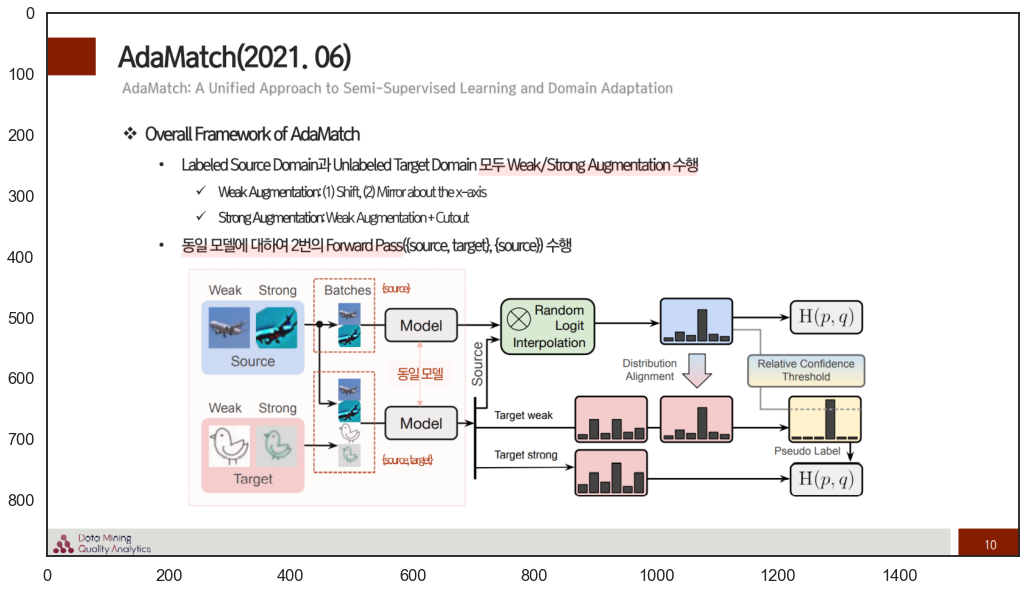

In [15]:
adamatch_img = Image.open('./Img/3.png')

adamatch_img_np = np.asarray(adamatch_img)

plt.figure(figsize=(20, 10))
plt.imshow(adamatch_img_np);

- 먼저 batch에는 (1) Weakly Augmented Source images & Labels, (2) Strongly Augmented Source images, (3) Weakly Augmented Target images (4) Strongly Augmented Target images 총 4가지가 있습니다.
    - 이때 Target은 Unlabeled 임을 가정하여 학습 도중 labels을 활용하지 않습니다.
- 그리고 앞서 언급했던 바와 같이 AdaMatch는 Forward를 2번 수행합니다.
    1. __First Forward__: 첫 번째 Forward에는 Source Domain과 Target Domain을 모두 합쳐서(concat) 하나의 input으로 활용해줍니다. 이를 `input_all`이라 지정하였으며, 이를 통해 산출되는 logit은 `logits_source_prime`(원문에서는 $Z'$로 표기)입니다.
    2. __Second Forward__: 두 번째 Forward에서는 Source Domain만 활용하여 `logits_source_2prime`($Z''$)를 산출합니다.

### Train process 2: Random Logit Interpolation

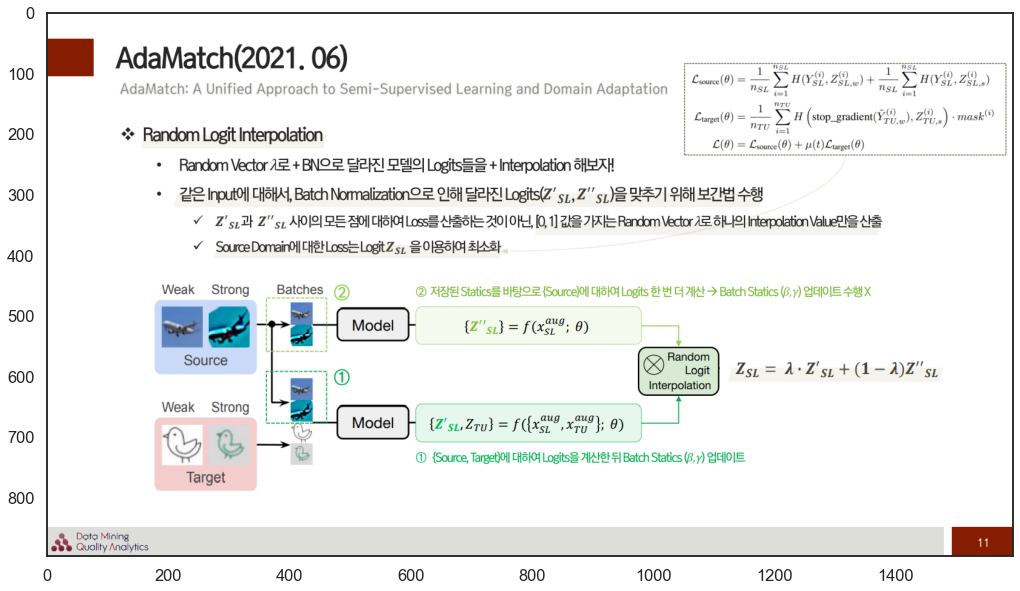

In [16]:
adamatch_img = Image.open('./Img/4.png')

adamatch_img_np = np.asarray(adamatch_img)

plt.figure(figsize=(20, 10))
plt.imshow(adamatch_img_np);

- 그렇다면 Source Domain에 대한 이미지 데이터는 2번의 forward에 따라 2개의 output이 산출됩니다. `logit_source_prime`($Z'$)과 `logit_source_2prime`($Z''$)가 바로 그것입니다.
    - 이 두 가지 logits은 왜 값이 달라질까요? 바로 Source와 Target을 모두 활용한 `input_all`에 대해서는 BatchNorm을 통한 통계량 값을 업데이트 하지만, Source만을 활용한 `input_source`에 대해서는 BatchNorm Statistics를 업데이트 하지 않기 때문입니다.
    - 이는 AdaMatch 내에서 BatchNorm을 통한 Domain Adaptation을 수행하고자 하기 때문입니다. 실제로 [DSBN](https://arxiv.org/abs/1906.03950)과 같은 알고리즘은 BatchNorm이 Domain내의 내부 공분산 변화를 줄이고 좀 더 안정적인 학습이 가능하다는 점에 주목하여 Batch 내 통계량 분포가 Source Domain에 과적합되지 않도록 Domain 별 BatchNorm을 수행하였습니다.
    - AdaMatch에서도 __Source와 Target이 함께 들어가는 Forward Pass에서는 먼저 BatchNorm을 통해 통계량을 업데이트하고, 그 다음 Source Domain만을 활용해 logits 값을 산출합니다. 이때 BatchNorm Statistics가 각각 다르니, 같은 Source Domain에 대해 나오는 output $Z'_{SL}$ 과 $Z''_{SL}$은 조금 다를 것__ 입니다.
　   
<br/>
　   
- 이때 __Random Logit Interpolation__ 에서는 두 가지의 output을 선형 보간법(Interpplation)을 통해 하나의 output으로 맞추어주는 작업을 수행합니다. 이는 아래와 같은 식으로 계산됩니다.
    $$Z_{SL} = \lambda Z'_{SL}+(1-\lambda)\cdot Z''_{SL} $$
    - 위 식에서 $\lambda$는 0과 1 사이 값을 가지는 Random Vector입니다. 저자들은 $Z'_{SL}$ 과 $Z''_{SL}$ 사이의 모든 $Z_{SL}$ 값에 대하여 Source Loss를 최소화 하는 대신, 무작위의 하나의 지점을 골라 최소화 하더라도 학습이 진행됨에 따라 결과적으로는 Global Optimum을 찾아갈 것이라 주장하고 있습니다.
    - 따라서 __Random__ Vector $\lambda$를 통해, Source에 대한 2가지 __Logit__ 을 __Inpterpolation__ 하는 작업을 진행합니다.

<br/>

- 본 튜토리얼에서 $\lambda$는 $Z'_{SL}$과 동일한 차원을 가진 벡터를 생성하였습니다. `torch.rand_like`을 이용하면 0과 1 사이의 값을 가지며 입력 값(`logits_source_prime`)과 동일한 차원을 가지는 벡터가 output으로 도출됩니다.
    - `random_lambda = torch.rand_like(logits_source_prime).to(self.device)`
- 이후 최종적으로 나오는 Source에 대한 final logits은 아래와 같이 계산합니다.
    - `logit_source_final = (random_lambda * logits_source_prime) + ((1-random_lambda) * logits_source_2prime)`

### Train process 3: Distribution Alignment

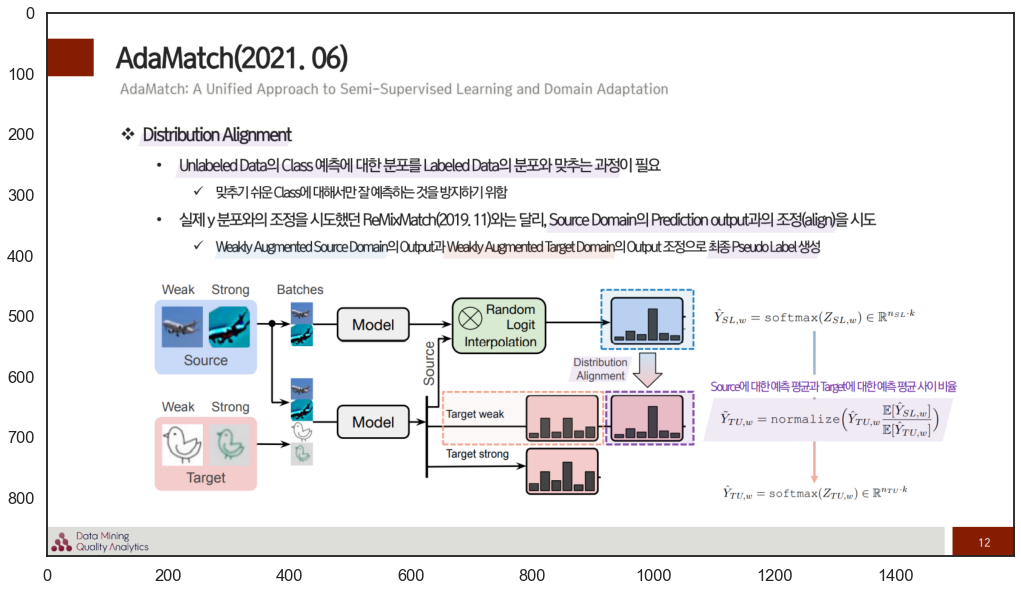

In [17]:
adamatch_img = Image.open('./Img/5.png')

adamatch_img_np = np.asarray(adamatch_img)

plt.figure(figsize=(20, 10))
plt.imshow(adamatch_img_np);

- ReMixMatch(2019)에서 제안한 바와 같이, Unlabeled Data의 성능을 높이기 위해서는 실제 Label Distribution과 맞추어주는 작업이 필요합니다. 이를 __Distribution Alignment__ 라 합니다.
- 이때 AdaMatch에서는 __ReMixMatch와는 달리, 실제 Label Distribution이 아닌 Weakly Augmented Source Domain의 Output Distribution과의 조정을 시도__ 하고 있습니다.

<br/>

- 따라서 처음에는 Weakly Augmented Source Domain에 대한 final output 값을 도출하고, 이후 Weakly Augmented Target Domain에 대한 pseudo label 값을 도출합니다.
    - 이는 각각 `pseudo_label_source`, `pseudo_label_target` 변수 명으로 표현하였습니다.

- 원문에서는 Target Unlabeled Pseudo Label을 아래와 같은 식으로 재조정합니다.
    $$\hat{Y}_{TU, w} = normalize(\hat{Y}_{TU,w} \frac{E[\hat{Y}_{SL,w}]}{E[\hat{Y}_{TU,w}]})$$
    - 즉 Weakly Augmented Source Domain의 예측 값 평균과 Weakly Augmented Target Domain의 예측 값 평균을 나누어주고, logits 합이 1이 되도록 normalize 해주는 것입니다.

<br/>

- 위 식을 본 튜토리얼에서는 아래와 같이 구현하였습니다.
    - `ratio_of_expected_value = (1e-6+torch.mean(pseudo_label_source)) / (1e-6+torch.mean(pseudo_label_target))`
        - 이때 Expected Value에 1e-6이 들어간 것은 일종의 보정 값입니다. 이는 [AdaMatch Original Code](https://github.com/google-research/adamatch/blob/main/domain_adaptation/adamatch.py)에서도 확인하실 수 있습니다.
    - `final_pseudo_label = F.normalize((pseudo_label_target*ratio_of_expected_value), p=2, dim=1)`은 L2 Normalization을 수행한 이후 Target Domain에 대한 최종 pseudo label 값입니다.

### Train process 4: Relative Confidence Threshold

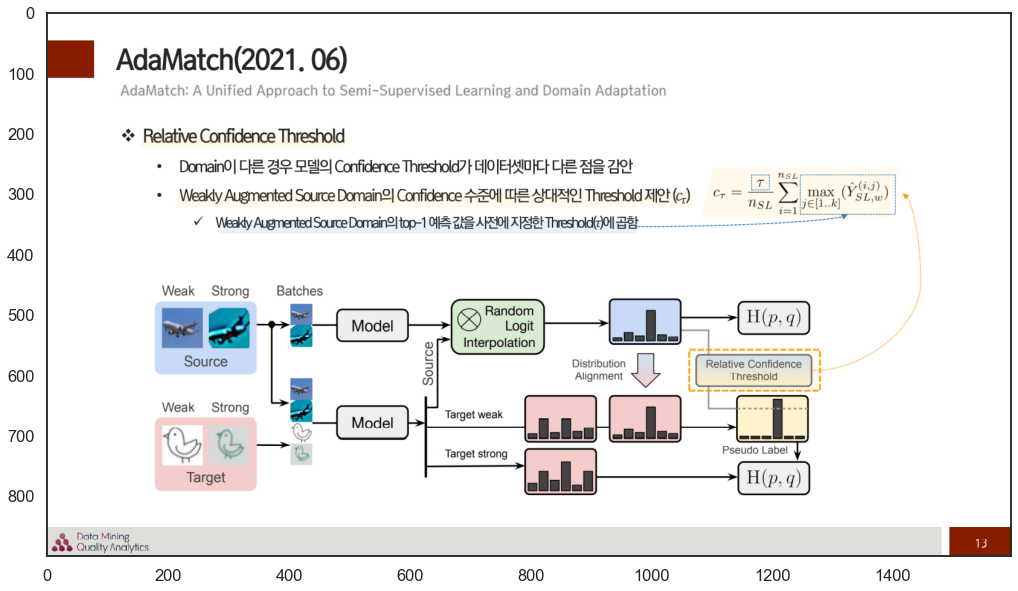

In [18]:
adamatch_img = Image.open('./Img/6.png')

adamatch_img_np = np.asarray(adamatch_img)

plt.figure(figsize=(20, 10))
plt.imshow(adamatch_img_np);

- 더불어 Domain이 다른 경우 모델의 Confidence Threshold가 다른 점을 감안하여, AdaMatch에서는 __Relative Confidence Threshold__ 를 제안합니다.
- 말 그대로, Target Domain의 Pseudo Label을 결정함에 있어서, 절대적인 Global Threshold($\tau$)를 일괄 적용하는 대신, Weakly Source Domain의 top-1 prediction 값을 이용해 Confidence 값을 상대적인 값($c_{\tau}$)으로 바꾸어주는 것입니다.
- 원문에서는 $c_{\tau}$를 아래와 같은 식으로 계산합니다.
$$c_{\tau} = \frac{\tau}{n_{SL}} \sum_{i=1}^{n_{SL}} \underset{j \in [1, ..., k]}{max}(\tilde{Y}_{SL,w}^{(i,j)})$$

<br/>

- 본 튜토리얼에서는 위 과정을 아래와 같은 코드로 구현하였습니다.
    - `pseudo_label_source_max = torch.max(pseudo_label_source, dim=1)[0]`
    - `c_tau = self.args.tau * torch.mean(pseudo_label_source_max, 0)`
- 따라서 Target Domain에 대한 최종 Pseudo Label은 `torch.max(final_pseudo_label, dim=1)`을 통해 나온 `final_pseudo_label` 값이 됩니다.
    - 이때 `mask = (final_pseudo_label_max >= c_tau).float()`는, Relative Confidence Threshold 값을 넘는 label만 Pseudo Label로 이용하겠다는 의미입니다.

### Train process 5: Calculate Loss

- AdaMatch 원문 Section 3.1 Method Description을 참고하면, 알고리즘의 최종 Loss는 아래와 같은 식으로 계산됩니다.
$$L(\theta) = L_{source}(\theta) + \mu(t)L_{target}(\theta)$$
- 즉, 최종 Loss는 Source Domain에 대한 Loss와 Target Domain에 대한 Loss로 구분됩니다.
    1. __Source Loss__ $L_{source}(\theta) = \frac{1}{n_{SL}}\sum_{i=1}^{n_{SL}}H(Y_{SL}^{(i)}, Z_{SL,w}^{(i)})+\frac{1}{n_{SL}}\sum_{i=1}^{n_{SL}}H(Y_{SL}^{(i)}, Z_{SL,s}^{(i)})$
        - Labeled Source에 대한 Loss는 전형적인 Supervised Loss의 형태로서, Weakly Augmented Source Domain의 Logits $Z_{SL, w}$과 Strongly Augmented Source Domain의 Logits $Z_{SL, s}$를 Label $Y_{SL}$과 비교하여 그 차이가 최소화 되도록 합니다.
    2. __Target Loss__ $L_{target}(\theta) = \frac{1}{n_{TU}} \sum_{i=1}^{n_{TU}}H(stop_gradient(\hat{Y}_{TU,w}^{(i)}), Z_{TU,s}^{(i)})\cdot mask^{(i)}$
        - Target Loss도 기본 형태는 masked 된 Pseudo Label (Confidence를 넘는 Weakly Augmented Target Samples의 Logits)과 Strongly Augmented Target Logits의 Cross Entropy를 최소화 하는 형태입니다.
        - 이때 mask의 기준, 즉 cofidence threshold는 global threshold $\tau$를 일괄 적용하는 대신, Train Process 4에서 설명한 Relative Confidence Thredhols $c_{\tau}$를 적용합니다.
        - `stop_gradient`는 gradient가 역전파되는 것을 막는 기법입니다. 이는 모델이 보다 빠르게 수렴할 수 있도록 하는 일종의 장치입니다.
    3. __Overall Loss__ $L(\theta)$: 최종 Loss는 Source Loss와 Target Loss를 더한 꼴이지만, Target Domain에 대한 Loss 앞에는 $\mu(t)$라는 가중치를 곱해줍니다.
        - 이 $\mu(t)$는 warmup function으로, 학습의 매 step마다 unlabeled dataset에 대한 loss를 통제하는 기능을 합니다. Unsupervised Domain Adaptation 분야에서는 종종 Unlabeled Target Domain에 대한 loss에 가중치를 붙여주곤 합니다. [Domain Adversarial Training of Neural Network](https://arxiv.org/pdf/1505.07818.pdf) 등이 바로 그 예이죠.
        - 이 역시 모델의 수렴속도를 빠르게 하기 위한 장치로, accuracy 성능에는 영향을 주지 않아야 하기에, 원문에서는 $\mu(t)=\frac{1}{2}-cos(min(\pi, 2\pi / T))/2$를 이용하여 계산하였습니다. 이때 T는 Training Step을 의미합니다.
            - 해당 식을 이용하면 $\mu$ 값이 학습 초반에는 0에서 1 사이의 값을 가지다가, 학습이 절반 이상 진행된 후에는 1의 값을 가지게 될 것입니다.
    

### Define Logger
- 학습 및 검증 시 모델 성능을 logging 할 함수입니다.
- 본 튜토리얼에서는 [`rich` 라이브러리](https://rich.readthedocs.io/en/stable/introduction.html)를 이용하여 logger를 정의합니다. logger를 위해 사용되는 라이브러리는 tqdm 등을 사용해도 무방합니다.

In [12]:
def touch(filepath: str, mode: str='w'):
    assert mode in ['a', 'w']
    directory, _ = os.path.split(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    open(filepath, mode).close()


def get_rich_logger(logfile: str = None, level=logging.INFO):
    myLogger = logging.getLogger()

    # File handler
    if logfile is not None:
        touch(logfile)
        fileHandler = logging.FileHandler(logfile)
        fileHandler.setFormatter(logging.Formatter("%(asctime)s [%(levelname)-5.5s] %(message)s"))
        myLogger.addHandler(fileHandler)

    # Rich handler
    width, _ = shutil.get_terminal_size()
    console = Console(color_system='256', width=width)
    richHandler = RichHandler(console=console)
    richHandler.setFormatter(logging.Formatter("%(message)s"))
    myLogger.addHandler(richHandler)

    # Set level
    myLogger.setLevel(level)

    return myLogger

# Define and Get logger
logfile = os.path.join(result_dir, 'main.log')
logger = get_rich_logger(logfile=logfile)

## Train and Evaluate

이제 직접 구현한 `AdaMatch` Class 내의 `run` method를 이용하여 학습 및 검증을 진행하도록 하겠습니다.
- `run` method에서는 args에서 지정된 epochs 수만큼 train을 진행시키는 한편, accuracy 값에 따라 best_model을 저장하도록 합니다.

In [13]:
start = time.time()

adamatch = AdaMatch(args=args, device=device, result_dir=result_dir)
best_model, epoch_history = adamatch.run(logger=logger)

end_sec = time.time() - start

if logger is not None:
        end_min = end_sec / 60
        logger.info(f"Total Training Time: {end_min: 2f} minutes")
        logger.handlers.clear()

Output()

[12/26/22 22:24:04] INFO      Epoch: [ 1/20] ( 1) | train_loss: ]8;id=703443;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=963438;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             3.030 | source_accuracy: 14.933 |                  
                             target_accuracy: 3.300 |                           

[12/26/22 22:40:43] INFO      Epoch: [ 2/20] ( 1) | train_loss: ]8;id=276431;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=869239;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.100 |                  
                             target_accuracy: 3.300 |                           

[12/26/22 22:45:40] INFO      Epoch: [ 3/20] ( 1) | train_loss: ]8;id=382612;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=499835;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.767 |                  
                             target_accuracy: 3.133 |                           

[12/26/22 22:53:41] INFO      Epoch: [ 4/20] ( 1) | train_loss: ]8;id=878228;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=628715;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.200 |                  
                             target_accuracy: 3.200 |                           

[12/26/22 23:08:35] INFO      Epoch: [ 5/20] ( 1) | train_loss: ]8;id=445612;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=93769;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.900 |                  
                             target_accuracy: 3.200 |                           

[12/26/22 23:18:56] INFO      Epoch: [ 6/20] ( 1) | train_loss: ]8;id=970440;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=109729;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.267 |                  
                             target_accuracy: 3.300 |                           

[12/26/22 23:21:20] INFO      Epoch: [ 7/20] ( 1) | train_loss: ]8;id=685834;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=536896;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.600 |                  
                             target_accuracy: 3.200 |                           

[12/26/22 23:36:06] INFO      Epoch: [ 8/20] ( 1) | train_loss: ]8;id=224175;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=47557;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.800 |                  
                             target_accuracy: 3.233 |                           

[12/26/22 23:43:55] INFO      Epoch: [ 9/20] ( 1) | train_loss: ]8;id=548079;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=446997;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.900 |                  
                             target_accuracy: 3.300 |                           

[12/26/22 23:46:28] INFO      Epoch: [10/20] ( 1) | train_loss: ]8;id=230279;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=566295;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.100 |                  
                             target_accuracy: 3.233 |                           

[12/27/22 00:03:02] INFO      Epoch: [11/20] ( 1) | train_loss: ]8;id=300478;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=662273;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.000 |                  
                             target_accuracy: 3.133 |                           

[12/27/22 00:10:27] INFO      Epoch: [12/20] ( 1) | train_loss: ]8;id=5916;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=413306;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.167 |                  
                             target_accuracy: 3.200 |                           

[12/27/22 00:17:18] INFO      Epoch: [13/20] ( 1) | train_loss: ]8;id=514031;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=618933;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.367 |                  
                             target_accuracy: 3.133 |                           

[12/27/22 00:27:21] INFO      Epoch: [14/20] ( 1) | train_loss: ]8;id=174086;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=604097;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.133 |                  
                             target_accuracy: 3.067 |                           

[12/27/22 00:37:30] INFO      Epoch: [15/20] ( 1) | train_loss: ]8;id=345174;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=758638;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.733 |                  
                             target_accuracy: 3.133 |                           

[12/27/22 00:45:36] INFO      Epoch: [16/20] ( 1) | train_loss: ]8;id=434185;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=655585;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.933 |                  
                             target_accuracy: 3.167 |                           

[12/27/22 00:48:17] INFO      Epoch: [17/20] ( 1) | train_loss: ]8;id=962672;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=97442;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.000 |                  
                             target_accuracy: 3.167 |                           

[12/27/22 01:05:11] INFO      Epoch: [18/20] ( 1) | train_loss: ]8;id=789504;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=689216;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 14.933 |                  
                             target_accuracy: 3.167 |                           

[12/27/22 01:13:40] INFO      Epoch: [19/20] ( 1) | train_loss: ]8;id=169264;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=957608;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.033 |                  
                             target_accuracy: 3.233 |                           

[12/27/22 01:28:21] INFO      Epoch: [20/20] ( 1) | train_loss: ]8;id=135760;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py\3460415005.py]8;;\:]8;id=11200;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\3460415005.py#62\62]8;;\
                             0.000 | source_accuracy: 15.000 |                  
                             target_accuracy: 3.167 |                           

                    INFO     Total Training Time:  203.482998   ]8;id=850823;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\1109552769.py\1109552769.py]8;;\:]8;id=148888;file://C:\Users\JihyunKim\AppData\Local\Temp\ipykernel_19812\1109552769.py#10\10]8;;\
                             minutes                                            

### [결과 해석]

- 모델 학습이 모두 종료되었습니다. 총 학습 시간은 203.5분이었으며, epochs 내내 Accuracy 성능이 낮은 것을 확인할 수 있습니다.
- 그렇다면 Test용의 Target Domain Loader를 통해 모델의 최종 성능을 확인해보겠습니다.

In [14]:
test_acc = adamatch.evaluate(target_test_loader, best_model)
rich.print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 3.00%

- From the scratch로 구현한 AdaMatch의 Test 성능은 3%의 정확도를 기록하였습니다. 이처럼 낮은 성능을 보이는 이유가 무엇일까요?
    1. 이미지 해상도를 32x32로 매우 낮추어 모델 학습이 어려웠을 가능성
    2. train/test용 데이터 수를 3000/1500장으로 대폭 줄여 학습이 덜 되었을 가능성
    3. epochs 수가 적어 학습이 덜 되었을 가능성
    4. Class 개수가 345개로, 매우 많은 Category를 분류해야 하는 상대적으로 어려운 Task였다는 점
    5. uratio를 2로 줄여, 학습 과정에서 보여지는 target samples의 수가 원문보다 줄었다는 점
    상기 총 5가지의 이유로 낮은 성능에 대한 원인을 짐작해볼 수 있습니다.

-----

### Conclusion
- 이번 튜토리얼에서는 2021년 6월 발표된 AdaMatch 알고리즘을 PyTorch를 이용해 from the scratch로 구현 후 기본 성능을 확인해보았습니다.
    - Test 성능은 그리 좋지 않았으나, DomainNet의 Target Domain(clipart)의 분포가 Source의 것(real)과 많이 다르고, Class 개수가 345개나 된다는 점을 감안해야 합니다
- AdaMatch는 Semi-Supervised Learning과 Domain Adaptation을 하나의 Framework 내에서 해결할 수 있도록 제안한 알고리즘이며, 특히 Labeled Smaples과 Unlabeled Smaples 간 Marginal Distribution이 다를 때 유용하게 사용될 수 있습니다.
    - 이는 (1) Random Logit Interpolation, (2) Distribution Alignment, (3) Relative Confidence Threshold 3가지 기법을 기반으로 합니다.
- 그러나 AdaMatch는 Source Domain이나 Target Domain이 여러 개인 상황에서는 바로 활용하기가 어렵고, Domain Adaptation에 관한 technique이 Batch Normalization에 한정되어 있습니다.
    - 저는 현재 Domain Apdatation에 관한 연구를 진행 중인데, 향후 Source Domain에 여러 개인 상황(Multi-Source)을 가정함과 더불어 다른 adaptation technique을 활용한 SSDA 분야를 연구하고 싶다는 생각을 가지게 되었습니다.

---

## References
[Paper]
- Berthelot, D., Roelofs, R., Sohn, K., Carlini, N., & Kurakin, A. (2021). Adamatch: A unified approach to semi-supervised learning and domain adaptation. arXiv preprint arXiv:2106.04732.
- Chang, W. G., You, T., Seo, S., Kwak, S., & Han, B. (2019). Domain-specific batch normalization for unsupervised domain adaptation. In Proceedings of the IEEE/CVF conference on Computer Vision and Pattern Recognition (pp. 7354-7362).
- Ganin, Y., Ustinova, E., Ajakan, H., Germain, P., Larochelle, H., Laviolette, F., ... & Lempitsky, V. (2016). Domain-adversarial training of neural networks. The journal of machine learning research, 17(1), 2096-2030.
- Zhuang, F., Qi, Z., Duan, K., Xi, D., Zhu, Y., Zhu, H., ... & He, Q. (2020). A comprehensive survey on transfer learning. Proceedings of the IEEE, 109(1), 43-76.


[github]
- https://github.com/google-research/adamatch/blob/main/semi_supervised_domain_adaptation/adamatch.py
- https://github.com/zysymu/AdaMatch-pytorch/
- https://keras.io/examples/vision/adamatch/
- https://github.com/smkim7-kr/AdaMatch-pytorch